FFR120: Homework 1 by Richard Blücher

Exercise 1

In [2]:
import numpy as np
# Parameters for the Lennard-Jones potential.
m = 1  # Mass (units of m0).
m_disc = 10 # Disc mass
r_disc = 10 # Disc radius
sigma = 1  # Size (units of sigma0).
eps = 1  # Energy (unit of epsilon0).
v0 = 10  # Initial speed (units of v0 = sqrt((2 * epsilon0) / m0)).

# Parameters for the simulation.
N_particles = 25**2  # Number of particles.
full_time = 401 # Time for simulation to run

dt = 0.005   # Time step (units of t0 = sigma * sqrt(m0 /(2 * epsilon0))).

L = 260  # Box size (units of sigma0).
x_min, x_max, y_min, y_max = -L/2, L/2, -L/2, L/2

cutoff_radius = 5 * sigma  # Cutoff_radius for neighbours list.

In [3]:
# Generate initial positions on a grid and orientations at random.
x0, y0 = np.meshgrid(
    np.linspace(- L / 2, L / 2, int(np.sqrt(N_particles))),
    np.linspace(- L / 2, L / 2, int(np.sqrt(N_particles))),
)
x0 = x0.flatten()[:N_particles]
y0 = y0.flatten()[:N_particles]
phi0 = (2 * np.random.rand(N_particles) - 1) * np.pi

# Initial values of disc
x0_disc = 0
y0_disc = 0
v0_disc = 0

# Initialize the neighbour list.
def list_neighbours(x, y, N_particles, cutoff_radius):
    '''Prepare a neigbours list for each particle.'''
    neighbours = []
    neighbour_number = []
    for j in range(N_particles):
        distances = np.sqrt((x - x[j]) ** 2 + (y - y[j]) ** 2)
        neighbor_indices = np.where(distances <= cutoff_radius)
        neighbours.append(neighbor_indices)
        neighbour_number.append(len(neighbor_indices))
    return neighbours, neighbour_number

neighbours, neighbour_number = list_neighbours(x0, y0, N_particles, cutoff_radius)

# Distance to disc function
def disc_dist(x_disc, y_disc, x, y):
    
    distances = np.sqrt((x_disc - x) ** 2 + (y_disc - y) ** 2)
    return distances


# If particles are to close to disc, remove them
disc_distances = disc_dist(x0_disc, y0_disc, x0, y0)
index_to_remove = np.where(disc_distances <= r_disc + 3*sigma)
x0 = np.delete(x0, index_to_remove)
y0 = np.delete(y0, index_to_remove)
phi0 = np.delete(phi0, index_to_remove)
N_particles = len(x0)



# Initialize the variables for the leapfrog algorithm.
# Current time srep.
x = x0
y = y0
x_half = np.zeros(N_particles)
y_half = np.zeros(N_particles)
v = v0
phi = phi0
vx = v0 * np.cos(phi0)
vy = v0 * np.sin(phi0)

x_disc = x0_disc
y_disc = y0_disc
x_disc_half = 0
y_disc_half = 0
v_disc = v0_disc
phi_disc = 0
vx_disc = v0_disc * np.cos(phi_disc)
vy_disc = v0_disc * np.sin(phi_disc)

# Next time step.
nx = np.zeros(N_particles)
ny = np.zeros(N_particles)
nv = np.zeros(N_particles)
nphi = np.zeros(N_particles)
nvx = np.zeros(N_particles)
nvy = np.zeros(N_particles)

nx_disc = 0
ny_disc = 0
nv_disc = 0
nphi_disc = 0
nvx_disc = 0
nvy_disc = 0



In [4]:
def total_force_cutoff(x, y, N_particles, sigma, epsilon, neighbours):
    '''
    Calculate the total force on each particle due to the interaction with a 
    neighbours list with the particles interacting through a Lennard-Jones 
    potential.
    '''
    Fx = np.zeros(N_particles)
    Fy = np.zeros(N_particles)
    for i in range(N_particles):
        for j in list(neighbours[i][0]):
            if i != j:
                r2 = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2
                r = np.sqrt(r2)
                ka2 = sigma ** 2 / r2
                
                # Force on i due to j.
                F = 24 * epsilon / r * (2 * ka2 ** 6 - ka2 ** 3)  # Modulus.
                
                Fx[i] += F * (x[i] - x[j]) / r
                Fy[i] += F * (y[i] - y[j]) / r
    return Fx, Fy

In [5]:
def LJ_force(x_disc, y_disc, x, y, epsilon, sigma):
    Fx = np.zeros(N_particles)
    Fy = np.zeros(N_particles)
    r = disc_dist(x_disc, y_disc, x, y) - r_disc
    ka2 = sigma ** 2 / r**2
    F = 24 * epsilon / r * (2 * ka2 ** 6 - ka2 ** 3)

    Fx += F * (x_disc - x) / r
    Fy += F * (y_disc - y) / r

    return -Fx, -Fy

In [6]:
Fx, Fy = LJ_force(x0_disc, y0_disc, x0, y0, eps, sigma)

In [7]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *
import math

visuals_on = False # To turn on/off visual simulation

if visuals_on:
    window_size = 600

    tk = Tk()
    tk.geometry(f'{window_size + 20}x{window_size + 20}')
    tk.configure(background='#000000')

    canvas = Canvas(tk, background='#ECECEC')  # Generate animation window 
    tk.attributes('-topmost', 0)
    canvas.place(x=10, y=10, height=window_size, width=window_size)

    disc = canvas.create_oval(
        (x_disc - r_disc / 2) / L * window_size + window_size / 2, 
        (y_disc - r_disc / 2) / L * window_size + window_size / 2,
        (x_disc + r_disc / 2) / L * window_size + window_size / 2, 
        (y_disc + r_disc / 2) / L * window_size + window_size / 2,
        outline='#000000', 
        fill='#000000',
    )

    particles = []
    for j in range(0, N_particles):
        particles.append(
            canvas.create_oval(
                (x[j] - sigma / 2) / L * window_size + window_size / 2, 
                (y[j] - sigma / 2) / L * window_size + window_size / 2,
                (x[j] + sigma / 2) / L * window_size + window_size / 2, 
                (y[j] + sigma / 2) / L * window_size + window_size / 2,
                outline='#00C0C0', 
                fill='#00C0C0',
            )
        )

step = 0

# For plotting disc positions
disc_pos = np.zeros((int(full_time/dt), 2))

def stop_loop(event):
    global running
    running = False
if visuals_on:
    tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.
while running:
    disc_pos[step] = [x_disc, y_disc]

    x_half = x + 0.5 * vx * dt      
    y_half = y + 0.5 * vy * dt   

    x_disc_half = x_disc + 0.5 * vx_disc * dt
    y_disc_half = y_disc + 0.5 * vy_disc * dt


    # fx, fy = \
    #     total_force_cutoff(x_half, y_half, N_particles, sigma, eps, neighbours)
    fx, fy = LJ_force(x_disc_half, y_disc_half, x_half, y_half, sigma, eps)
    
    nvx = vx + fx / m * dt
    nvy = vy + fy / m * dt
        
    nx = x_half + 0.5 * nvx * dt
    ny = y_half + 0.5 * nvy * dt    

    nvx_disc = vx_disc + sum(-fx) / m_disc * dt # Force negative for disc if positive for particles
    nvy_disc = vy_disc + sum(-fy) / m_disc * dt

    nx_disc = x_disc_half + 0.5 * nvx_disc * dt
    ny_disc = y_disc_half + 0.5 * nvy_disc * dt  
      
    
    ## Reflecting boundary conditions.
    # For disc
    if nx_disc < x_min:
            nx_disc = x_min + (x_min - nx_disc)
            nvx_disc = - nvx_disc

    if nx_disc > x_max:
        nx_disc = x_max - (nx_disc - x_max)
        nvx_disc = - nvx_disc

    if ny_disc < y_min:
        ny_disc = y_min + (y_min - ny_disc)
        nvy_disc = - nvy_disc
            
    if ny_disc > y_max:
        ny_disc = y_max - (ny_disc - y_max)
        nvy_disc = - nvy_disc

    # For particles
    for j in range(N_particles):
        if nx[j] < x_min:
            nx[j] = x_min + (x_min - nx[j])
            nvx[j] = - nvx[j]

        if nx[j] > x_max:
            nx[j] = x_max - (nx[j] - x_max)
            nvx[j] = - nvx[j]

        if ny[j] < y_min:
            ny[j] = y_min + (y_min - ny[j])
            nvy[j] = - nvy[j]
            
        if ny[j] > y_max:
            ny[j] = y_max - (ny[j] - y_max)
            nvy[j] = - nvy[j]
    
    # Update velocities
    nv = np.sqrt(nvx ** 2 + nvy ** 2)
    for i in range(N_particles):
        nphi[i] = math.atan2(nvy[i], nvx[i])

    nv_disc = np.sqrt(nvx_disc ** 2 + nvy_disc ** 2)
    nphi_disc = math.atan2(nvy_disc, nvx_disc)
    
    

    # Update variables for next iteration.
    x = nx
    y = ny
    vx = nvx
    vy = nvy
    v = nv
    phi = nphi

    x_disc = nx_disc
    y_disc = ny_disc
    vx_disc = nvx_disc
    vy_disc = nvy_disc
    v_disc = nv_disc
    phi_disc = nphi_disc
        
    # Update animation frame.
    if visuals_on:
        if step % 100 == 0:        
            canvas.coords(
                disc,
                (nx_disc - r_disc / 2) / L * window_size + window_size / 2,
                (ny_disc - r_disc / 2) / L * window_size + window_size / 2,
                (nx_disc + r_disc / 2) / L * window_size + window_size / 2,
                (ny_disc + r_disc / 2) / L * window_size + window_size / 2,
            )
            for j, particle in enumerate(particles):
                canvas.coords(
                    particle,
                    (nx[j] - sigma / 2) / L * window_size + window_size / 2,
                    (ny[j] - sigma / 2) / L * window_size + window_size / 2,
                    (nx[j] + sigma / 2) / L * window_size + window_size / 2,
                    (ny[j] + sigma / 2) / L * window_size + window_size / 2,
                )
                        
            tk.title(f'Time {step * dt:.1f} - Iteration {step}')
            tk.update_idletasks()
            tk.update()
            time.sleep(.001)  # Increase to slow down the simulation.    


    if step == full_time/dt - 1:
        running = False
    step += 1

if visuals_on:
    tk.update_idletasks()
    tk.update()
    tk.mainloop()  # Release animation handle (close window to finish).

Text(0, 0.5, 'y')

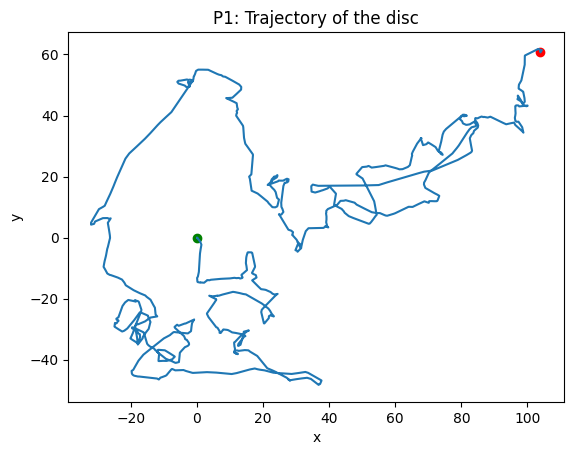

In [13]:
from matplotlib import pyplot as plt
plt.plot(disc_pos[:,0], disc_pos[:,1])
plt.scatter(0,0, c='g')
plt.scatter(disc_pos[-1, 0], disc_pos[-1, 1], c='r')
plt.title('P1: Trajectory of the disc')
plt.xlabel('x')
plt.ylabel('y')


In [14]:
N = step
times = np.linspace(0, full_time, N)
msd2 = np.zeros(N)
disc_pos = disc_pos.T
for n in range(N):
    msd2[n] = 1/(N-n) * np.sum((disc_pos[0, n+1:N]-disc_pos[0, 1:N-n])**2 + (disc_pos[1, n+1:N]-disc_pos[1, 1:N-n])**2)




Q1: The diffusion coefficient D = 9.661


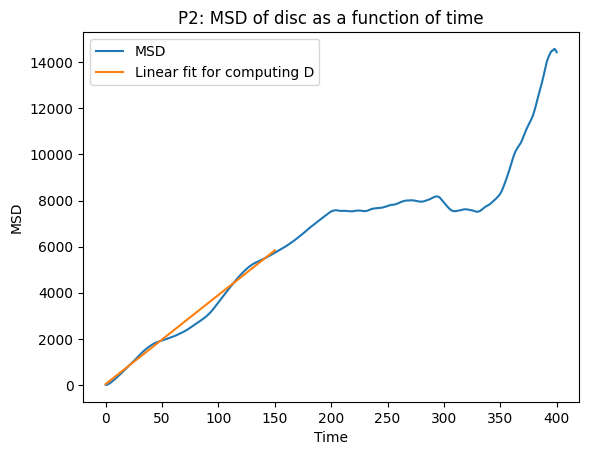

In [15]:
msd_fit = np.polyfit(times[:int(150/dt)], msd2[:int(150/dt)], 1)

plt.plot(times[:-int(1/dt)], msd2[:-int(1/dt)], label = 'MSD')
plt.plot(times[:int(150/dt)], times[:int(150/dt)]*msd_fit[0] + msd_fit[0], label = 'Linear fit for computing D')

plt.xlabel('Time')
plt.ylabel('MSD')
plt.title('P2: MSD of disc as a function of time')
plt.legend()

print(f'Q1: The diffusion coefficient D = {msd_fit[0]/4:.4}')


Exercise 2

In [44]:
N = 100  # Size of the splin lattice.
H = 0  # External field.
H_list = np.array([-5, -2, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, 5])
J = 1  # Spin-spin coupling.
T = 5  # Temperature. Temperatura critica ~2.269.
T_list = np.array([0.1, 0.2, 0.5, 1, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 5])
N_iterations = 5000 # Nr of iterations to run simulation for

sl = 2 * np.random.randint(2, size=(N, N)) - 1

N_up = np.sum(sl + 1) / 2
N_down = N * N - N_up

print(f"Spin lattice created:  N_up={N_up}  N_down={N_down}")

Spin lattice created:  N_up=5031.0  N_down=4969.0


In [45]:
def neighboring_spins(i_list, j_list, sl):
    """
    Function returning the position of the neighbouring spins of a list of 
    spins identified by their positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """

    Ni, Nj = sl.shape  # Shape of the spin lattice.
    
    # Position neighbors right.
    i_r = i_list  
    j_r = list(map(lambda x:(x + 1) % Nj, j_list))   

    # Position neighbors left.
    i_l = i_list  
    j_l = list(map(lambda x:(x - 1) % Nj, j_list))   

    # Position neighbors up.
    i_u = list(map(lambda x:(x - 1) % Ni, i_list))  
    j_u = j_list  

    # Position neighbors down.
    i_d = list(map(lambda x:(x + 1) % Ni, i_list)) 
    j_d = j_list   

    # Spin values.
    sl_u = sl[i_u, j_u]
    sl_d = sl[i_d, j_d]
    sl_l = sl[i_l, j_l]
    sl_r = sl[i_r, j_r]

    return sl_u, sl_d, sl_l, sl_r

In [46]:
def energies_spins(i_list, j_list, sl, H, J):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    sl_u, sl_d, sl_l, sl_r = neighboring_spins(i_list, j_list, sl)
    
    sl_s = sl_u + sl_d + sl_l + sl_r 
    
    E_u = - H - J * sl_s
    E_d =   H + J * sl_s 
    
    return E_u, E_d

In [47]:
def energies_spins(i_list, j_list, sl, H, J):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    sl_u, sl_d, sl_l, sl_r = neighboring_spins(i_list, j_list, sl)
    
    sl_s = sl_u + sl_d + sl_l + sl_r 
    
    E_u = - H - J * sl_s
    E_d =   H + J * sl_s 
    
    return E_u, E_d

In [48]:
def probabilities_spins(i_list, j_list, sl, H, J, T):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    E_u, E_d = energies_spins(i_list, j_list, sl, H, J)
    
    Ei = np.array([E_u, E_d])
    
    Z = np.sum(np.exp(- Ei / T), axis=0)  # Partition function.
    pi = 1 / np.array([Z, Z]) * np.exp(- Ei / T)  # Probability.

    return pi, Z       

In [49]:
def compute_magnetization(sl):
    m = np.sum(sl)/sl.shape[0]**2
    return m

Task 1

In [22]:
import random
import time
from tkinter import *
H_iteration = 0
m = np.zeros_like(H_list)
for H in H_list:
    
    f = 0.05  # Number of randomly selected spins to flip-test.

    m_many = 0
    n_average = 0

    visuals_on = False
    if visuals_on:
        N_skip = 10 # Visualize status every N_skip steps. 

        window_size = 600

        tk = Tk()
        tk.geometry(f'{window_size + 20}x{window_size + 20}')
        tk.configure(background='#000000')

        canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
        tk.attributes('-topmost', 0)
        canvas.place(x=10, y=10, height=window_size, width=window_size)

    Nspins = np.size(sl)  # Total number of spins in the spin lattice.
    Ni, Nj = sl.shape

    S = int(np.ceil(Nspins * f))  # Number of randomly selected spins.

    step = 0

    def stop_loop(event):
        global running
        running = False
    if visuals_on:
        tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
    running = True  # Flag to control the loop.
    while running:
        ns = random.sample(range(Nspins), S)

        i_list = list(map(lambda x: x % Ni, ns)) 
        j_list = list(map(lambda x: x // Ni, ns)) 

        pi, Z = probabilities_spins(i_list, j_list, sl, H, J, T)

        rn = np.random.rand(S)
        for i in range(S):
            if rn[i] > pi[0, i]:
                sl[i_list[i], j_list[i]] = -1
            else:
                sl[i_list[i], j_list[i]] = 1

        if visuals_on:
            # Update animation frame.
            if step % N_skip == 0:        
                canvas.delete('all')
                spins = []
                for i in range(Ni):
                    for j in range(Nj):
                        spin_color = '#FFFFFF' if sl[i,j] == 1 else '#000000'
                        spins.append(
                            canvas.create_rectangle(
                                j / Nj * window_size, 
                                i / Ni * window_size,
                                (j + 1) / Nj * window_size, 
                                (i + 1) / Ni * window_size,
                                outline='', 
                                fill=spin_color,
                            )
                        )
                
                tk.title(f'Iteration {step}')
                tk.update_idletasks()
                tk.update()
                time.sleep(0.1)  # Increase to slow down the simulation.

        if step >= N_iterations - 200:
            m_many += compute_magnetization(sl)
            n_average += 1

        step += 1

        if step == N_iterations:
            running = False

    m[H_iteration] = m_many/n_average
    print(f'For H: {H} -> m = {m[H_iteration]}')
    H_iteration += 1

    if visuals_on:
        tk.update_idletasks()
        tk.update()
        tk.mainloop()  # Release animation handle (close window to finish).

For H: -5.0 -> m = -0.9386640000000004
For H: -2.0 -> m = -0.7309230000000001
For H: -1.0 -> m = -0.4759560000000001
For H: -0.5 -> m = -0.268254
For H: -0.2 -> m = -0.11753799999999996
For H: -0.1 -> m = -0.061207999999999964
For H: 0.0 -> m = -0.011061999999999995
For H: 0.1 -> m = 0.077897
For H: 0.2 -> m = 0.12632899999999997
For H: 0.5 -> m = 0.2629659999999999
For H: 1.0 -> m = 0.478506
For H: 2.0 -> m = 0.7221420000000003
For H: 5.0 -> m = 0.9406270000000003


Q1: Magnetic susceptibility χ = 0.6268389999999998


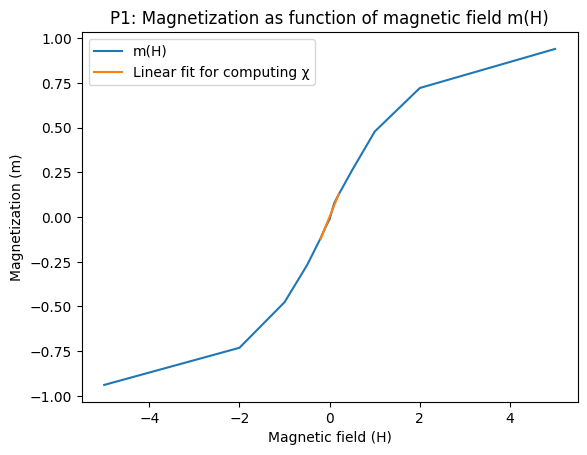

In [23]:
linfit = np.polyfit(H_list[4:9], m[4:9], 1)
plt.plot(H_list, m, label = 'm(H)')
plt.plot(H_list[4:9], H_list[4:9]*linfit[0]+linfit[1], label = 'Linear fit for computing χ')


print(f'Q1: Magnetic susceptibility χ = {linfit[0]}')


plt.xlabel('Magnetic field (H)')
plt.ylabel('Magnetization (m)')
plt.title('P1: Magnetization as function of magnetic field m(H)')
plt.legend()


Task 2

In [24]:
import random
import time
from tkinter import *
T_iteration = 0
H = 0.1
m = np.zeros_like(T_list)
for T in T_list:
    if step >= 300:
        H = 0
    f = 0.05  # Number of randomly selected spins to flip-test.

    m_many = 0
    n_average = 0

    visuals_on = False
    if visuals_on:
        N_skip = 10 # Visualize status every N_skip steps. 

        window_size = 600

        tk = Tk()
        tk.geometry(f'{window_size + 20}x{window_size + 20}')
        tk.configure(background='#000000')

        canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
        tk.attributes('-topmost', 0)
        canvas.place(x=10, y=10, height=window_size, width=window_size)

    Nspins = np.size(sl)  # Total number of spins in the spin lattice.
    Ni, Nj = sl.shape

    S = int(np.ceil(Nspins * f))  # Number of randomly selected spins.

    step = 0

    def stop_loop(event):
        global running
        running = False
    if visuals_on:
        tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
    running = True  # Flag to control the loop.
    while running:
        ns = random.sample(range(Nspins), S)

        i_list = list(map(lambda x: x % Ni, ns)) 
        j_list = list(map(lambda x: x // Ni, ns)) 

        pi, Z = probabilities_spins(i_list, j_list, sl, H, J, T)

        rn = np.random.rand(S)
        for i in range(S):
            if rn[i] > pi[0, i]:
                sl[i_list[i], j_list[i]] = -1
            else:
                sl[i_list[i], j_list[i]] = 1

        if visuals_on:
            # Update animation frame.
            if step % N_skip == 0:        
                canvas.delete('all')
                spins = []
                for i in range(Ni):
                    for j in range(Nj):
                        spin_color = '#FFFFFF' if sl[i,j] == 1 else '#000000'
                        spins.append(
                            canvas.create_rectangle(
                                j / Nj * window_size, 
                                i / Ni * window_size,
                                (j + 1) / Nj * window_size, 
                                (i + 1) / Ni * window_size,
                                outline='', 
                                fill=spin_color,
                            )
                        )
                
                tk.title(f'Iteration {step}')
                tk.update_idletasks()
                tk.update()
                time.sleep(0.1)  # Increase to slow down the simulation.

        if step >= N_iterations - 200:
            m_many += compute_magnetization(sl)
            n_average += 1

        step += 1

        if step == N_iterations:
            running = False

    m[T_iteration] = m_many/n_average
    print(f'For T: {T} -> m = {m[T_iteration]}')
    T_iteration += 1

    if visuals_on:
        tk.update_idletasks()
        tk.update()
        tk.mainloop()  # Release animation handle (close window to finish).

For T: 0.1 -> m = 1.0
For T: 0.2 -> m = 1.0
For T: 0.5 -> m = 1.0
For T: 1.0 -> m = 0.9995529999999998
For T: 2.0 -> m = 0.9221210000000006
For T: 2.1 -> m = 0.8720470000000003
For T: 2.2 -> m = 0.8227489999999998
For T: 2.3 -> m = 0.5928139999999998
For T: 2.4 -> m = 0.2634059999999999
For T: 2.5 -> m = 0.226388
For T: 2.6 -> m = -0.09487400000000001
For T: 2.7 -> m = -0.013729000000000002
For T: 2.8 -> m = -0.10682900000000001
For T: 2.9 -> m = -0.04572499999999999
For T: 3.0 -> m = 0.05541999999999998
For T: 5.0 -> m = -0.015895000000000006


Q2: My estimate of Tc = 2.35.
Reason: this is where the slope is steepest --> small changes in T impact m much,
which happens around Tc.


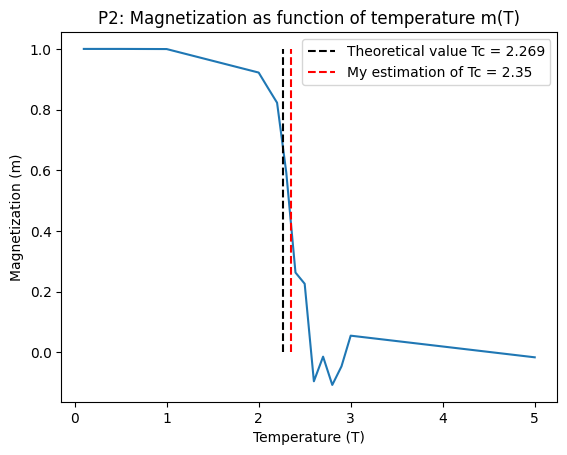

In [25]:
plt.plot(T_list, m)
plt.vlines(2.269, 0, 1, 'k', linestyles='dashed', label = 'Theoretical value Tc = 2.269')

temp_diffs = T_list[1:] - T_list[0:-1]
m_diffs = m[1:] - m[0:-1]
slope = m_diffs/temp_diffs

my_Tc = T_list[np.argmin(slope)]+temp_diffs[np.argmin(slope)]/2
print(f'Q2: My estimate of Tc = {my_Tc:.4}.')
print('Reason: this is where the slope is steepest --> small changes in T impact m much,')
print('which happens around Tc.')

plt.vlines(my_Tc, 0, 1, 'r', linestyles='dashed', label = f'My estimation of Tc = {my_Tc:.4}')


plt.xlabel('Temperature (T)')
plt.ylabel('Magnetization (m)')
plt.title('P2: Magnetization as function of temperature m(T)')
plt.legend()


Exercise 3

In [26]:
import numpy as np 
    
def grow_trees(forest, p):
    """
    Function to grow new trees in the forest.
    
    Parameters
    ==========
    forest : 2-dimensional array.
    p : Probability for a tree to be generated in an empty cell.
    """
    
    Ni, Nj = forest.shape  # Dimensions of the forest.
    
    new_trees = np.random.rand(Ni, Nj)

    new_trees_indices = np.where(new_trees <= p)
    forest[new_trees_indices] = 1
    
    return forest

In [27]:
def propagate_fire(forest, i0, j0):
    """
    Function to propagate the fire on a populated forest.
    
    Parameters
    ==========
    forest : 2-dimensional array.
    i0 : First index of the cell where the fire occurs.
    j0 : Second index of the cell where the fire occurs.
    """
    
    Ni, Nj = forest.shape  # Dimensions of the forest.

    fs = 0  # Initialize fire size.

    if forest[i0, j0] == 1:
        active_i = [i0]  # Initialize the list.
        active_j = [j0]  # Tnitialize the list. 
        forest[i0, j0] = -1  # Sets the tree on fire.
        fs += 1  # Update fire size.
        
        while len(active_i) > 0:
            next_i = []
            next_j = []
            for n in np.arange(len(active_i)):
                # Coordinates of cell up.
                i = (active_i[n] + 1) % Ni
                j = active_j[n]
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

                # Coordinates of cell down.
                i = (active_i[n] - 1) % Ni
                j = active_j[n]
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

                # Coordinates of cell left.
                i = active_i[n]
                j = (active_j[n] - 1) % Nj
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

                # Coordinates of cell right.
                i = active_i[n]
                j = (active_j[n] + 1) % Nj
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

            active_i = next_i
            active_j = next_j        
            
    return fs, forest

In [28]:
def complementary_CDF(f, f_max):
    """
    Function to return the complementary cumulative distribution function.
    
    Parameters
    ==========
    f : Sequence of values (as they occur, non necessarily sorted).
    f_max : Integer. Maximum possible value for the values in f. 
    """
    
    num_events = len(f)
    s = np.sort(np.array(f)) / f_max  # Sort f in ascending order.
    c = np.array(np.arange(num_events, 0, -1)) / (num_events)  # Descending.
    
    c_CDF = c
    s_rel = s

    return c_CDF, s_rel

In [29]:
N = 100  # Side of the forest.
N_list = np.array([16, 32, 64, 128, 256, 512, 1024])
p = 0.01  # Growth probability.
f = 0.2  # Lightning strike probability.



alphas = np.zeros(len(N_list))




target_num_fires = 300  





for a_ind, N in enumerate(N_list):

    alpha_many = 0
    for i in range(10):
        forest = np.zeros([N, N])  # Empty forest.
        Ni, Nj = forest.shape  # Sets the variables describing the shape.
        fire_size = []  # Empty list of fire sizes.
        fire_history = []  # Empty list of fire history.

        num_fires = 0
        while num_fires < target_num_fires:

            forest = grow_trees(forest, p)  # Grow new trees.
            
            p_lightning = np.random.rand()
            if p_lightning < f:  # Lightning occurs.
                i0 = np.random.randint(Ni)
                j0 = np.random.randint(Nj)
                
                fs, forest = propagate_fire(forest, i0, j0)
                if fs > 0:
                    fire_size.append(fs) 
                    num_fires += 1 
                    
                fire_history.append(fs)
                
            else:
                fire_history.append(0)

            forest[np.where(forest == -1)] = 0

        #print(f'Target of {target_num_fires} fire events reached')


        c_CDF, s_rel = complementary_CDF(fire_size, forest.size)

        min_rel_size = 1e-3
        max_rel_size = 1e-1


        is_min = np.searchsorted(s_rel, min_rel_size)
        is_max = np.searchsorted(s_rel, max_rel_size)

        # Note!!! The linear dependence is between the logarithms
        fit = np.polyfit(np.log(s_rel[is_min:is_max]),
                    np.log(c_CDF[is_min:is_max]), 1)

        beta = fit[0]
        #print(f'The empirical cCDF has an exponent beta = {beta:.4}')

        alpha = 1 - beta
        alpha_many += alpha

        #print(f'The empirical prob. distr. exponent: -alpha')
        #print(f'with alpha = {alpha:.4}')
        print(f'Size: {N}, iteration: {i+1}/10')
    alphas[a_ind] = alpha_many/10.0


Size: 16, iteration: 1/10
Size: 16, iteration: 2/10
Size: 16, iteration: 3/10
Size: 16, iteration: 4/10
Size: 16, iteration: 5/10
Size: 16, iteration: 6/10
Size: 16, iteration: 7/10
Size: 16, iteration: 8/10
Size: 16, iteration: 9/10
Size: 16, iteration: 10/10
Size: 32, iteration: 1/10
Size: 32, iteration: 2/10
Size: 32, iteration: 3/10
Size: 32, iteration: 4/10
Size: 32, iteration: 5/10
Size: 32, iteration: 6/10
Size: 32, iteration: 7/10
Size: 32, iteration: 8/10
Size: 32, iteration: 9/10
Size: 32, iteration: 10/10
Size: 64, iteration: 1/10
Size: 64, iteration: 2/10
Size: 64, iteration: 3/10
Size: 64, iteration: 4/10
Size: 64, iteration: 5/10
Size: 64, iteration: 6/10
Size: 64, iteration: 7/10
Size: 64, iteration: 8/10
Size: 64, iteration: 9/10
Size: 64, iteration: 10/10
Size: 128, iteration: 1/10
Size: 128, iteration: 2/10
Size: 128, iteration: 3/10
Size: 128, iteration: 4/10
Size: 128, iteration: 5/10
Size: 128, iteration: 6/10
Size: 128, iteration: 7/10
Size: 128, iteration: 8/10
S

In [30]:
print(alphas)

[1.30930068 1.29646287 1.25865257 1.22452589 1.18151023 1.14706912
 1.12578555]


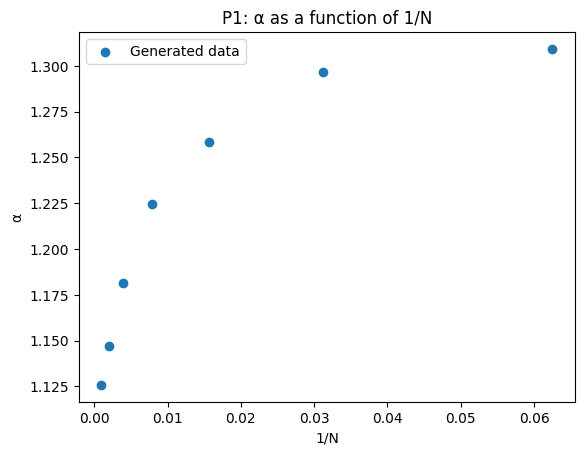

In [31]:
from matplotlib import pyplot as plt
plt.scatter(1/N_list, alphas, label = 'Generated data')
#plt.xscale('log')
#plt.xticks(1/N_list, ['1/16', '1/32', '1/64', '1/128', '1/256', '1/512', '1/1024'])

plt.xlabel('1/N')
plt.ylabel('α')
plt.title('P1: α as a function of 1/N')
plt.legend()

Using linear fit of log(1/N):
Q1: α when N^(-1) -> 0: -inf


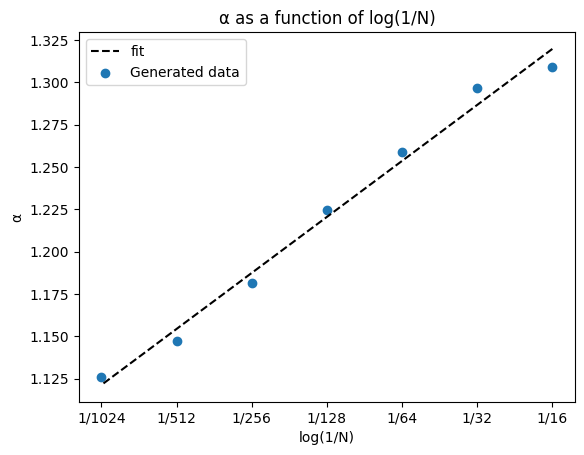

In [32]:
a_fit = np.polyfit(np.log(1/N_list), alphas, 1)



plt.plot(np.log(1/N_list), np.log(1/N_list)*a_fit[0] + a_fit[1], 'k--', label = 'fit')
plt.scatter(np.log(1/N_list), alphas, label = 'Generated data')

plt.xticks(np.log(1/N_list), ['1/16', '1/32', '1/64', '1/128', '1/256', '1/512', '1/1024'])

plt.xlabel('log(1/N)')
plt.ylabel('α')
plt.title('α as a function of log(1/N)')
plt.legend()

print('Using linear fit of log(1/N):')
print(f'Q1: α when N^(-1) -> 0: -inf')


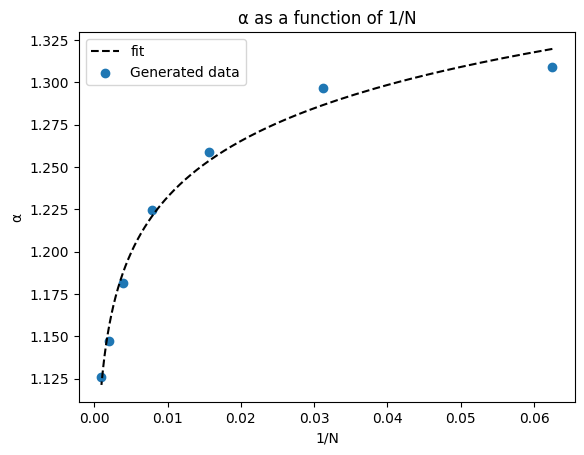

In [33]:
N_space = np.linspace(N_list[0], N_list[-1], 1000)
plt.plot(np.exp(np.log(1/N_space)), np.log(1/N_space)*a_fit[0] + a_fit[1], 'k--', label = 'fit')
plt.scatter(np.exp(np.log(1/N_list)), alphas, label = 'Generated data')
plt.xlabel('1/N')
plt.ylabel('α')
plt.title('α as a function of 1/N')
plt.legend()

When using a linear fit to unmodified data:
Q1: α when N^(-1) -> 0: 1.172


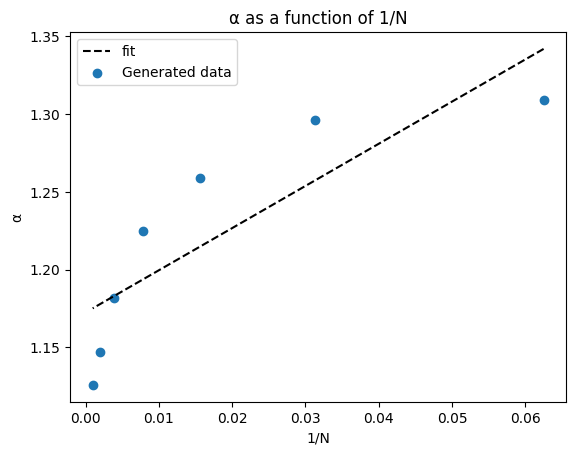

In [34]:
a1_fit = np.polyfit(1/N_list, alphas, 1)

plt.plot(1/N_list, 1/N_list*a1_fit[0] + a1_fit[1], 'k--', label = 'fit')
plt.scatter(1/N_list, alphas, label = 'Generated data')

plt.xlabel('1/N')
plt.ylabel('α')
plt.title('α as a function of 1/N')
plt.legend()

print('When using a linear fit to unmodified data:')
print(f'Q1: α when N^(-1) -> 0: {a1_fit[1]:.4}')

Q2: My first thought when seeing the data was that it looked logarithmic so after plotting α as a function of log(1/N) it seemed obvious that a linear fit to α(log(1/N)) would work well. As seen in the plots this fit is good but the result when extrapolating to 1/N -> 0 gives α = -infinity. This is far from the estimate of α = 1.15 given in Chapter 3 of the book. When realizing this I tried a linear fit to α(1/N) as seen in Fig 3.6 in the book. This fit looks much worse than both my previous one and the one in the book. However, extrapolating to 1/N -> 0 gives α = 1.178 which is quite close to the estimated α = 1.15.

Exercise 4

In [35]:
def neighbors_Moore(status):
    """
    Function to return the number of neighbors for each cell in status.
    
    Parameters
    ==========
    status : Current status.
    """

    # Initialize the neighbor count array
    n_nn = (
        np.roll(status, 1, axis=0) +  # Up.
        np.roll(status, -1, axis=0) +  # Down.
        np.roll(status, 1, axis=1) +  # Left.
        np.roll(status, -1, axis=1) +  # Right.
        np.roll(np.roll(status, 1, axis=0), 1, axis=1) +  # Up-Left.
        np.roll(np.roll(status, 1, axis=0), -1, axis=1) +  # Up-Right
        np.roll(np.roll(status, -1, axis=0), 1, axis=1) +  # Down-Left
        np.roll(np.roll(status, -1, axis=0), -1, axis=1)  # Down-Right
    )

    return n_nn

In [36]:
def apply_rule_2d(rule_2d, status):
    """
    Function to apply a 2-d rule on a status. Return the next status.
    
    Parameters
    ==========
    rule_2d : Array with size [2, 9]. Describe the CA rule.
    status : Current status.
    """
    
    Ni, Nj = status.shape  # Dimensions of 2-D lattice of the CA.
    next_status = np.zeros([Ni, Nj]) 
    
    # Find the number of neighbors.
    n_nn = neighbors_Moore(status) 
    for i in range(Ni):
        for j in range(Nj):
            next_status[i, j] = rule_2d[int(status[i, j]), int(n_nn[i, j])]
        
    return next_status

In [37]:
import time
from tkinter import *

visuals_on = False
N = 100
full_time = 1000
alive = np.zeros([5, full_time])
c = np.zeros([5, full_time])

for alive_ind in range(5):
    # Random initial state.
    gol = np.random.randint(2, size=[N, N])

    rule_2d = np.zeros([2, 9])

    # Game of Life's rules.
    rule_2d[0, :] = [0, 0, 0, 1, 0, 0, 0, 0, 0]  # New born from empty cell.
    rule_2d[1, :] = [0, 0, 1, 1, 0, 0, 0, 0, 0]  # Survival from living cell.


    Ni, Nj = gol.shape  # Sets the variables describing the shape.
    N_skip = 1 # Visualize status every N_skip steps. 
    window_size = 600

    if visuals_on:
        tk = Tk()
        tk.geometry(f'{window_size + 20}x{window_size + 20}')
        tk.configure(background='#000000')

        canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
        tk.attributes('-topmost', 0)
        canvas.place(x=10, y=10, height=window_size, width=window_size)

    step = 0

    def stop_loop(event):
        global running
        running = False
    if visuals_on:
        tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
    running = True  # Flag to control the loop.
    while running:
        alive[alive_ind, step] = np.sum(gol) # Count how many calls are alive
        prev_gol = gol # Save previus gol to compute C(t)

        gol = apply_rule_2d(rule_2d, gol)

        gol_switch = abs(prev_gol - gol) # Compare to know if cells switch
        nr_of_switches = np.sum(gol_switch)
        c[alive_ind, step] = nr_of_switches
        if visuals_on:    
        # Update animation frame.
            if step % N_skip == 0:        
                canvas.delete('all')
                gol_cells = []
                for i in range(Ni):
                    for j in range(Nj):
                        gol_cell_color = '#FFFFFF' if gol[i, j] == 1 \
                        else '#000000' 
                        gol_cells.append(
                            canvas.create_rectangle(
                                j / Nj * window_size, 
                                i / Ni * window_size,
                                (j + 1) / Nj * window_size, 
                                (i + 1) / Ni * window_size,
                                outline='', 
                                fill=gol_cell_color,
                            )
                        )
                
                tk.title(f'Iteration {step}')
                tk.update_idletasks()
                tk.update()
                time.sleep(0.1)  # Increase to slow down the simulation.
        if step == full_time-1:
            running = False
        
        
        step += 1

    if visuals_on:    
        tk.update_idletasks()
        tk.update()
        tk.mainloop()  # Release animation handle (close window to finish).

Task 1

Text(0.5, 1.0, 'P1: Alive cells as a function of the time step A(t)')

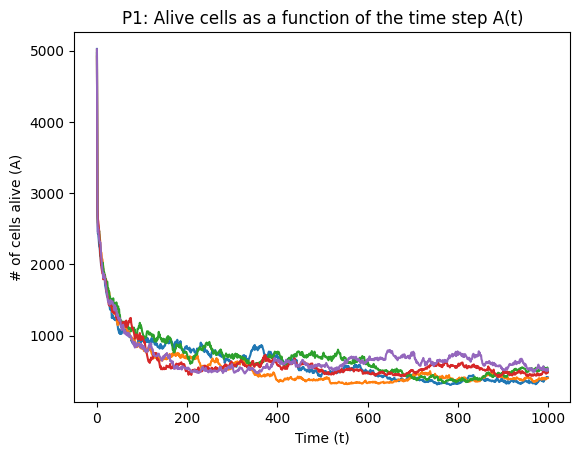

In [38]:
for i in range(alive.shape[0]):
    plt.plot(alive[i])

plt.xlabel('Time (t)')
plt.ylabel('# of cells alive (A)')
plt.title('P1: Alive cells as a function of the time step A(t)')

In [39]:
alive_density = alive/(N**2)

In [40]:
ensamble_mean_alive_density = np.mean(alive_density, axis=0)

I think Q1 here is ambiguous so forgive me for giving several answers.

Q1: The average density of alive cell per unit area is 0.06426.
Q1: The average density of alive cell per unit area after stabilizing is 0.05014.


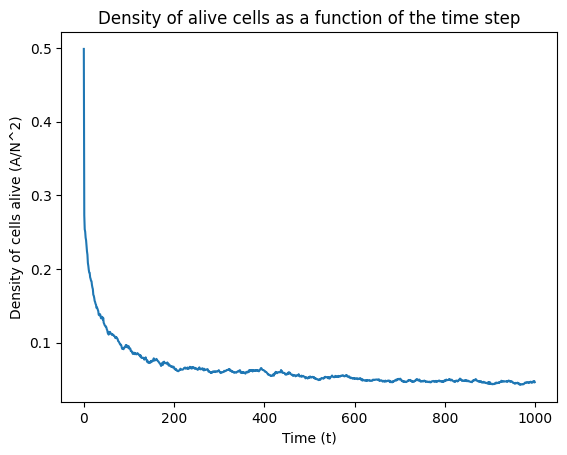

In [41]:
plt.plot(ensamble_mean_alive_density)

plt.xlabel('Time (t)')
plt.ylabel('Density of cells alive (A/N^2)')
plt.title('Density of alive cells as a function of the time step')

time_average_density = np.mean(ensamble_mean_alive_density)
time_average_density_stable = np.mean(ensamble_mean_alive_density[400:])

print(f'Q1: The average density of alive cell per unit area is {time_average_density:.4}.')
print(f'Q1: The average density of alive cell per unit area after stabilizing is {time_average_density_stable:.4}.')


Q2: After approximately 400 iterations a steady state is reached with a density around 0.05.

Task 2

Text(0.5, 1.0, '# of cells C change their state in the following time step C(t)')

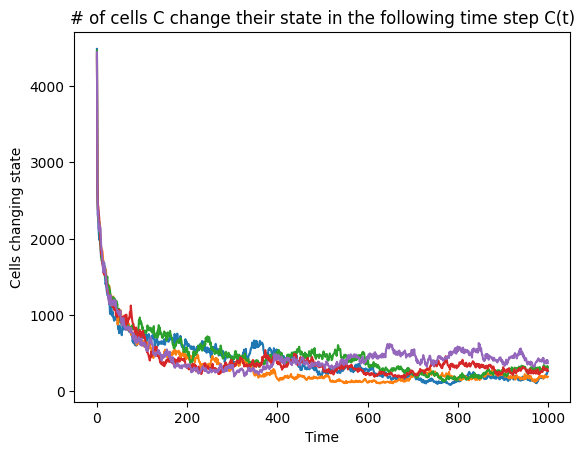

In [42]:
for i in range(c.shape[0]):
    plt.plot(c[i])

plt.xlabel('Time')
plt.ylabel('Cells changing state')
plt.title('# of cells C change their state in the following time step C(t)')


Text(0.5, 1.0, 'P2: # of cells C change their state in the following time step C(t)')

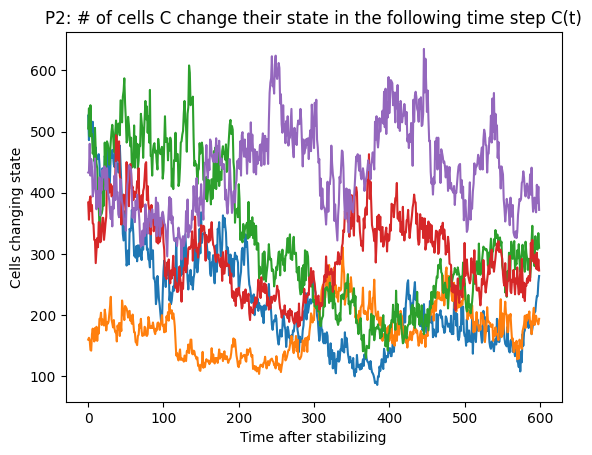

In [43]:


for i in range(c.shape[0]):
    plt.plot(c[i, 400:])

plt.xlabel('Time after stabilizing')
plt.ylabel('Cells changing state')
plt.title('P2: # of cells C change their state in the following time step C(t)')